Analysed a panel dataset of 840 UK firm-year observations to assess the impact of board gender diversity on financial performance.
Developed OLS regression models using robust standard errors to correct for heteroskedasticity and ensure valid inferences
Pinpointed a statistically significant, non-linear relationship, finding that firm performance (Tobin's Q) peaked with 22% female board representation.


In [1]:
# Environment Setup

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plotting style
sns.set_style("whitegrid")
plt.rc('figure', figsize=(10, 6))

In [2]:
# Data Loading and Preparation

file_path = 'GenderDirectorsData2.dta'
# --------------------------------

try:
    df = pd.read_stata(file_path)
    
    # Feature Engineering 
    df['lnsize'] = np.log(df['size'])
    df['pfdir'] = df['nfdir'] / df['ndir']

    print("Data loaded and features engineered successfully.")
    print(f"Total observations: {len(df)}\n")

    print("Descriptive Statistics for Key Variables:")
    print(df[['roa', 'tobinsq', 'pfdir', 'ndir', 'lnsize']].describe())
    
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please check the folder path printed above.")
    print("Either move the file there, or update the 'file_path' variable with the full path.")
except NameError as e:
    print(f"Error: {e}")
    print("This might be because 'df' was not created. Check your file path.")

Data loaded and features engineered successfully.
Total observations: 840

Descriptive Statistics for Key Variables:
              roa     tobinsq       pfdir        ndir      lnsize
count  840.000000  840.000000  840.000000  840.000000  840.000000
mean     5.969093    1.102189    0.141376    8.555952    6.276619
std     12.050222    1.005593    0.118930    2.401671    1.199904
min    -69.144699    0.017000    0.000000    3.000000    1.629241
25%      1.661100    0.594000    0.000000    7.000000    5.439754
50%      5.159390    0.831000    0.125000    8.000000    6.344687
75%     11.116575    1.193750    0.222222   10.000000    7.080391
max     43.977299    7.379000    0.545455   19.000000    9.410150


In [3]:
# Define the baseline formula (Model 1)
formula_1 = 'pfdir + ndir + lnsize + y10 + y12 + y14 + y16'

# --- Model 1A: ROA ---
model_1a = smf.ols(f'roa ~ {formula_1}', data=df).fit()
model_1a_robust = model_1a.get_robustcov_results(cov_type='HC3')

print("\n--- [Model 1A: ROA (Linear, Robust SE)] ---")
print(model_1a_robust.summary().tables[1])

# --- Model 1B: Tobin's Q ---
model_1b = smf.ols(f'tobinsq ~ {formula_1}', data=df).fit()
model_1b_robust = model_1b.get_robustcov_results(cov_type='HC3')

print("\n--- [Model 1B: Tobin's Q (Linear, Robust SE)] ---")
print(model_1b_robust.summary().tables[1])


--- [Model 1A: ROA (Linear, Robust SE)] ---
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.6147      2.916      3.983      0.000       5.891      17.338
pfdir         -1.9903      3.175     -0.627      0.531      -8.222       4.241
ndir           0.7554      0.164      4.604      0.000       0.433       1.077
lnsize        -3.1319      0.345     -9.083      0.000      -3.809      -2.455
y10            9.7687      1.731      5.643      0.000       6.371      13.166
y12            9.1397      1.716      5.328      0.000       5.772      12.507
y14            9.7014      1.783      5.440      0.000       6.201      13.202
y16            9.3663      1.793      5.223      0.000       5.846      12.886

--- [Model 1B: Tobin's Q (Linear, Robust SE)] ---
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [4]:
# Create the quadratic term
df['pfdir2'] = df['pfdir']**2

# Define the quadratic formula (Model 2)
formula_2 = 'pfdir + pfdir2 + ndir + lnsize + y10 + y12 + y14 + y16'

# --- Model 2B: Tobin's Q (Quadratic) ---
model_2b = smf.ols(f'tobinsq ~ {formula_2}', data=df).fit()
model_2b_robust = model_2b.get_robustcov_results(cov_type='HC3')

print("\n--- [Model 2B: Tobin's Q (Quadratic, Robust SE)] ---")
print(model_2b_robust.summary().tables[1])

# Perform F-test for joint significance
f_test_2b = model_2b_robust.f_test('pfdir = 0, pfdir2 = 0')
print("\n--- F-test for joint significance (pfdir, pfdir2) ---")
print(f_test_2b)


--- [Model 2B: Tobin's Q (Quadratic, Robust SE)] ---
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9791      0.198     15.051      0.000       2.591       3.368
pfdir          2.1878      0.602      3.632      0.000       1.006       3.370
pfdir2        -5.0633      1.365     -3.710      0.000      -7.742      -2.385
ndir           0.0297      0.011      2.620      0.009       0.007       0.052
lnsize        -0.4376      0.037    -11.866      0.000      -0.510      -0.365
y10            0.4453      0.088      5.044      0.000       0.272       0.619
y12            0.4930      0.080      6.192      0.000       0.337       0.649
y14            0.7260      0.099      7.328      0.000       0.532       0.921
y16            0.6346      0.096      6.589      0.000       0.446       0.824

--- F-test for joint significance (pfdir, pfdir2) ---
<F test: F=6.996663320

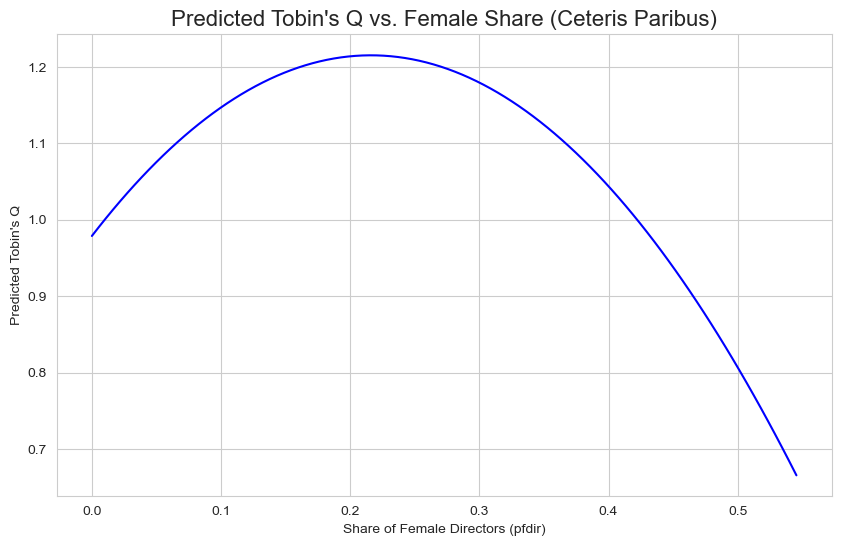

In [5]:
# 1. Calculate means of control variables
avg_ndir = df['ndir'].mean()
avg_lnsize = df['lnsize'].mean()

# 2. Create a range of pfdir values
pfdir_range = np.linspace(df['pfdir'].min(), df['pfdir'].max(), 100)

# 3. Build the hypothetical DataFrame
pred_df_q4 = pd.DataFrame({
    'pfdir': pfdir_range,
    'pfdir2': pfdir_range**2,
    'ndir': avg_ndir,
    'lnsize': avg_lnsize,
    'y10': 0, 'y12': 1, 'y14': 0, 'y16': 0
})

# 4. Generate predictions using the robust model
pred_df_q4['predicted_tobinsq'] = model_2b_robust.predict(pred_df_q4)

# 5. Plot the results
sns.lineplot(data=pred_df_q4, x='pfdir', y='predicted_tobinsq', color='blue')
plt.title("Predicted Tobin's Q vs. Female Share (Ceteris Paribus)", fontsize=16)
plt.xlabel("Share of Female Directors (pfdir)")
plt.ylabel("Predicted Tobin's Q")
plt.show()

In [6]:
# Create interaction terms
df['lnsizepfdir'] = df['lnsize'] * df['pfdir']
df['lnsizepfdir2'] = df['lnsize'] * df['pfdir2']

# Define the full interaction formula (Model 3)
formula_3 = 'pfdir + pfdir2 + ndir + lnsize + y10 + y12 + y14 + y16 + lnsizepfdir + lnsizepfdir2'

# --- Model 3B: Tobin's Q (Full Interaction) ---
model_3 = smf.ols(f'tobinsq ~ {formula_3}', data=df).fit()
model_3_robust = model_3.get_robustcov_results(cov_type='HC3')

print("\n--- [Model 3B: Tobin's Q (Interaction, Robust SE)] ---")
print(model_3_robust.summary().tables[1])

# Perform F-test for joint significance of interactions
f_test_3 = model_3_robust.f_test('lnsizepfdir = 0, lnsizepfdir2 = 0')
print("\n--- F-test for joint significance (Interaction Terms) ---")
print(f_test_3)


--- [Model 3B: Tobin's Q (Interaction, Robust SE)] ---
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.0943      0.301      6.963      0.000       1.504       2.685
pfdir           16.1040      4.142      3.888      0.000       7.974      24.234
pfdir2         -36.2212      8.940     -4.052      0.000     -53.768     -18.674
ndir             0.0340      0.012      2.945      0.003       0.011       0.057
lnsize          -0.2951      0.049     -6.038      0.000      -0.391      -0.199
y10              0.4324      0.088      4.896      0.000       0.259       0.606
y12              0.4664      0.081      5.743      0.000       0.307       0.626
y14              0.7158      0.099      7.254      0.000       0.522       0.910
y16              0.6437      0.095      6.759      0.000       0.457       0.831
lnsizepfdir     -2.2710      0.614     -3.701      0.

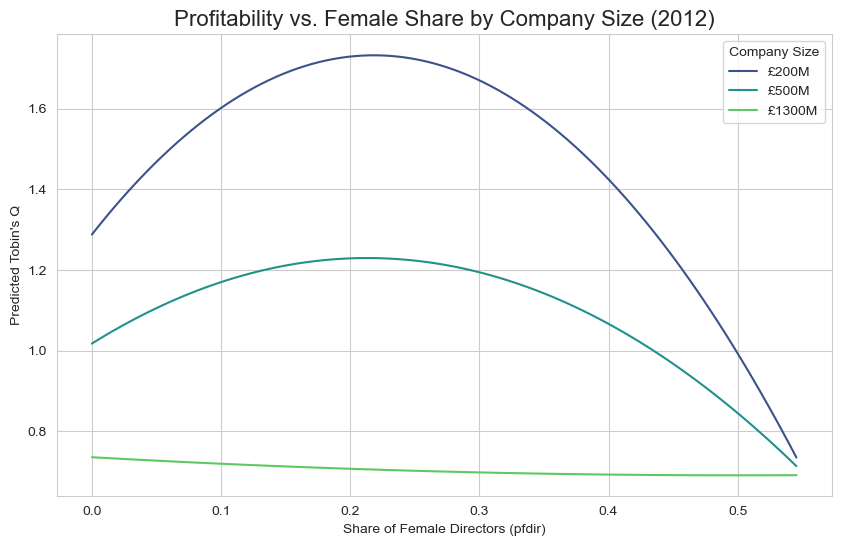

In [7]:
# 1. Define the hypothetical sizes and their log-transforms
sizes_to_plot = [200, 500, 1300]
ln_sizes = [np.log(s) for s in sizes_to_plot]

# (We still have avg_ndir and pfdir_range from before)

# 2. Loop to build the full hypothetical DataFrame
all_preds_list = []
for size_val, ln_size_val in zip(sizes_to_plot, ln_sizes):
    # Create a temporary DataFrame for this size
    temp_df = pd.DataFrame({
        'pfdir': pfdir_range,
        'pfdir2': pfdir_range**2,
        'ndir': avg_ndir,
        'lnsize': ln_size_val,
        'y10': 0, 'y12': 1, 'y14': 0, 'y16': 0
    })
    
    # Add the interaction terms *based on this hypothetical data*
    temp_df['lnsizepfdir'] = temp_df['lnsize'] * temp_df['pfdir']
    temp_df['lnsizepfdir2'] = temp_df['lnsize'] * temp_df['pfdir2']
    
    # Generate predictions using the final model (model_3_robust)
    temp_df['predicted_tobinsq'] = model_3_robust.predict(temp_df)
    
    # Add a label for plotting
    temp_df['Company Size'] = f'£{size_val}M'
    
    all_preds_list.append(temp_df)

# 3. Concatenate all results into one DataFrame
plot_df_q5 = pd.concat(all_preds_list)

# 4. Plot the results
sns.lineplot(data=plot_df_q5, x='pfdir', y='predicted_tobinsq', hue='Company Size', palette='viridis')
plt.title("Profitability vs. Female Share by Company Size (2012)", fontsize=16)
plt.xlabel("Share of Female Directors (pfdir)")
plt.ylabel("Predicted Tobin's Q")
plt.legend(title='Company Size')
plt.show()